In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.transform
import os

from sklearn import model_selection
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, add, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions, VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

keras.__version__

'2.7.0'

In [51]:
IMAGE_SIZE = 224
CHANNELS = 3
data_location = 'UCMerced_LandUse/Images'
category_names = os.listdir(data_location)
number_classes = len(category_names)

In [54]:
def process_image(image_folder, save_x, save_y, i): 
    images = os.listdir(image_folder) 
    for image in images: 
        image_path = image_folder + '/' + image
        orignal_image_size = Image.open(image_path)
        resized_image = orignal_image_size.resize((IMAGE_SIZE, IMAGE_SIZE), Image.ANTIALIAS)
        arr = np.asarray(resized_image).astype('float32') / 255.0
        save_x.append(arr)
        save_y.append([i])

In [55]:
save_x = [] 
save_y = [] 
i = 0 
for category in category_names:
    image_folder = data_location + '/' + category
    process_image(image_folder, save_x, save_y, i)
    i += 1 

In [56]:
labels = to_categorical(save_y, number_classes)
images = np.array(save_x)

In [62]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(images, labels, test_size=0.2, 
                                                                            stratify = labels, random_state=2021) 
x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=0.25, 
                                                                          stratify = y_train, random_state=2021) 

In [64]:
x_test.shape

(420, 224, 224, 3)

# Data augmentation

In [65]:
epochs = 30
learning_rate = 0.001
batch_size = 32
batches_per_epoch = y_train.shape[0] // batch_size
validation_steps = y_val.shape[0] // batch_size

image_gen = ImageDataGenerator(
    zoom_range = 0.1,
    width_shift_range = 5,   # pixel
    height_shift_range = 5,  # pixel
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 20
)
image_gen_test = ImageDataGenerator()

In [66]:
train_gen = image_gen.flow(np.array(x_train), y_train, batch_size = batch_size, shuffle = True)
val_gen = image_gen_test.flow(np.array(x_val), y_val, batch_size = batch_size, shuffle = True)

# Transfer learning

In [69]:
model = VGG16(include_top = False, input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

for layer in model.layers: 
    layer.trainable = False
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(number_classes, activation='softmax')(class1)

model = Model(inputs=model.inputs, outputs=output)

# model.summary()

In [13]:
# #Use resnet
# model = ResNet50(weights='imagenet', include_top = False, input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# for layer in model.layers:
#     layer.trainable = False
# gavg = GlobalAveragePooling2D()(model.layers[-1].output)
# class1 = Dense(128, activation='relu')(gavg)
# output = Dense(number_classes, activation='softmax')(class1)

# model = Model(inputs=model.inputs, outputs=output)

# # model.summary()

In [70]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy']) 

checkpoint_best_model = 'SavedModels/VGG.hdf5'
# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=90)
mc = ModelCheckpoint(checkpoint_best_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True) 

In [71]:
print('training...')

history = model.fit(
                x=train_gen,
                steps_per_epoch=batches_per_epoch, 
                epochs=epochs, 
                validation_data=val_gen,
                validation_steps=validation_steps,
                verbose = 2,
                callbacks=[mc]
                )

print('done')

training...
Epoch 1/30

Epoch 00001: val_accuracy improved from -inf to 0.77404, saving model to SavedModels\VGG.hdf5
39/39 - 104s - loss: 3.5564 - accuracy: 0.5008 - val_loss: 0.9764 - val_accuracy: 0.7740 - 104s/epoch - 3s/step
Epoch 2/30

Epoch 00002: val_accuracy improved from 0.77404 to 0.83654, saving model to SavedModels\VGG.hdf5
39/39 - 108s - loss: 0.5440 - accuracy: 0.8233 - val_loss: 0.5165 - val_accuracy: 0.8365 - 108s/epoch - 3s/step
Epoch 3/30

Epoch 00003: val_accuracy did not improve from 0.83654
39/39 - 109s - loss: 0.3544 - accuracy: 0.8893 - val_loss: 0.5119 - val_accuracy: 0.8269 - 109s/epoch - 3s/step
Epoch 4/30

Epoch 00004: val_accuracy did not improve from 0.83654
39/39 - 108s - loss: 0.2984 - accuracy: 0.9015 - val_loss: 0.5960 - val_accuracy: 0.8269 - 108s/epoch - 3s/step
Epoch 5/30

Epoch 00005: val_accuracy improved from 0.83654 to 0.85096, saving model to SavedModels\VGG.hdf5
39/39 - 101s - loss: 0.2903 - accuracy: 0.9047 - val_loss: 0.5003 - val_accuracy: 

# Evaluate the model

In [72]:
checkpoint_best_model = 'SavedModels/VGG.hdf5'
saved_model = load_model(checkpoint_best_model)

_, acc = saved_model.evaluate(x_train, y_train, verbose=0)
print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(x_val, y_val, verbose=0)
print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(x_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))

Model evaluate on train, Accuracy 99.127
Model evaluate on val, Accuracy 91.667
Model evaluate on test, Accuracy 90.952


# Predict on testing set

In [73]:
predictions = saved_model.predict(x=x_test, batch_size=batch_size)
y_pred = to_categorical(np.argmax(predictions, axis=1), number_classes)
y_pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32)

In [75]:
y_pred = to_categorical(np.argmax(predictions, axis=1), number_classes)
report_string = classification_report(y_test, y_pred, target_names=category_names)
print(report_string)

                   precision    recall  f1-score   support

     agricultural       1.00      0.90      0.95        20
         airplane       1.00      1.00      1.00        20
  baseballdiamond       1.00      0.80      0.89        20
            beach       1.00      1.00      1.00        20
        buildings       0.82      0.90      0.86        20
        chaparral       1.00      1.00      1.00        20
 denseresidential       0.79      0.55      0.65        20
           forest       0.86      0.95      0.90        20
          freeway       1.00      1.00      1.00        20
       golfcourse       0.85      0.85      0.85        20
           harbor       1.00      1.00      1.00        20
     intersection       0.95      0.95      0.95        20
mediumresidential       0.68      0.85      0.76        20
   mobilehomepark       0.85      0.85      0.85        20
         overpass       1.00      0.95      0.97        20
       parkinglot       0.95      1.00      0.98       

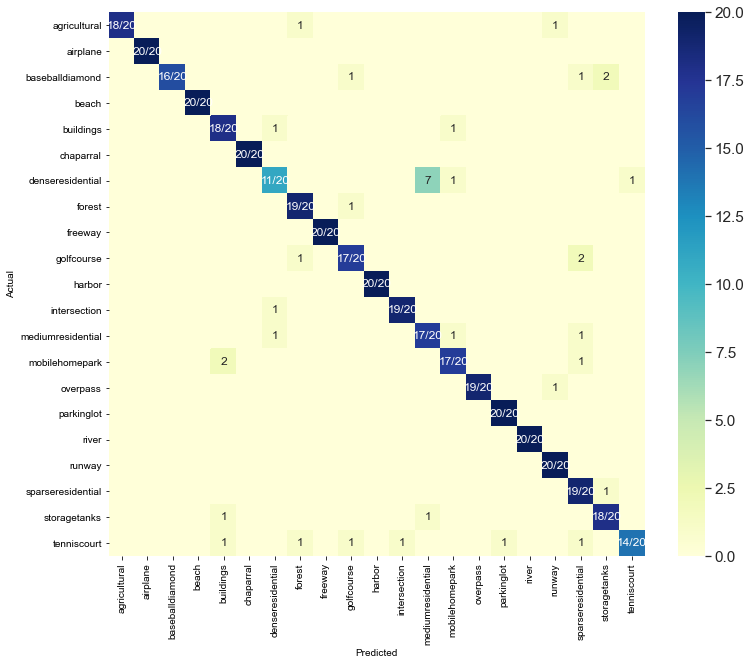

In [76]:
def plot_cm(y_true, y_pred, figsize=(12,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%d/%d' % (c, s)
            elif c == 0:
                annot[i, j] = ''
            elif i<j:
                annot[i, j] = '%d' % (c)
            else:
                annot[i, j] = '%d' % (c)
    #cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm = pd.DataFrame(cm, index=category_names, columns=category_names)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax, annot_kws={"fontsize":12})
    
plot_cm( y_test.argmax(axis=1), predictions.argmax(axis=1))